In [1]:
#!/usr/bin/env python
# coding: utf-8
# @author Avijit Roy

In [6]:
import random
import pickle
import random
import time
import pprint
import os
import math
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [7]:
distance_graph_array = []

In [8]:

class GridWorld:
    def __init__(self,epsilon=0.2,alpha=0.3,gamma=0.9):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = {}
        self.last_grid = None
        self.q_last = 0.0
        self.state_action_last = None
     
    
            
    def game_begin(self):
        self.last_grid = None
        self.q_last  = 0.0
        self.state_action_last = None
    
    
    
    def epsilon_greedy(self, state, possible_moves):
        self.last_grid = state
        if(random.random() < self.epsilon):
            move = random.choice(possible_moves)
            self.state_action_last = (self.last_grid,move)
            return move
        else:
            Q_list = []
            for action in possible_moves:
                Q_list.append(self.getQ(self.last_grid,action))
            maxQ = max(Q_list)
            
            if Q_list.count(maxQ) > 1:
                best_options = [i for i in range(len(possible_moves)) if Q_list[i] == maxQ]
                i = random.choice(best_options)
            else:
                i = Q_list.index(maxQ)
            self.state_action_last = (self.last_grid, possible_moves[i])
            self.q_last = self.getQ(self.last_grid, possible_moves[i])
            return possible_moves[i]
                
 

        
    def getQ(self, state, action):
        if(self.Q.get((state,action))) is None:
            self.Q[(state,action)] = 1.0
        return self.Q.get((state,action))
    
        
        
    def updateQ(self, reward, state, possible_moves):
        q_list = []
        for moves in possible_moves:
            q_list.append(self.getQ((state), moves))
        if q_list:
            max_q_next = max(q_list)
        else:
            max_q_next = 0.0
        self.Q[self.state_action_last] = self.q_last + self.alpha * ((reward + self.gamma*max_q_next) - self.q_last)
        
        
        
    def saveQtable(self, file_name):
        with open(file_name, 'wb') as handle:
            pickle.dump(self.Q, handle, protocol = pickle.HIGHEST_PROTOCOL)
        
        
      
    def loadQtable(self, file_name):
        with open(file_name, 'rb') as handle:
            self.Q = pickle.load(handle)
        
        
        

In [9]:
class RunAgents:
    def __init__(self, training = False,beta = -5):
        self.grid = [' '] * 81
        
        self.done = False
        self.computer_1 = None
        self.computer_2 = None
        
        self.training = training
        self.agent1 = None
        self.agent2 = None
        self.reward_states = [30,31]
        self.max_iter = 500
        self.beta = beta
        self.A_visited_states = []
        self.B_visited_states = []
        x = datetime.datetime.now()
        self.time = str(x)[0:10]

        
    def reset(self):
        if(self.training):
            self.grid = [' '] * 81
            self.grid[0] = 'A'
            self.grid[80] = 'B'
            self.A_visited_states = []
            self.B_visited_states = []
            return


    def evaluate(self, ch):
        
        location = self.find_location(ch)
        distance = self.proximity(ch)
        proximity_reward = -math.exp(self.beta * distance)
        i = 100
        for x in self.reward_states:
            i += 1
            if location == x:
                proximity_reward = 100 + proximity_reward   #(((np.random.randn()*i)+i) + proximity_reward )

        #print("Reward: ",proximity_reward)    
        return proximity_reward , False



    def find_location(self,ch):
        location = 0
        for i,char in enumerate(self.grid):
            if char == ch:
                location = i
        return location



    def proximity(self,ch):
        location_A = self.find_location('A')
        location_B = self.find_location('B')
        dist = abs(location_A - location_B)
        vertical_dist = int(dist/9)
        horizontal_dist = dist % 9
        return  math.sqrt((vertical_dist * vertical_dist) + (horizontal_dist * horizontal_dist))



        
    def possible_moves(self, ch):
        location_A = self.find_location('A')
        location_B = self.find_location('B')
        remove = None
        return_value = None
        if ch == 'A':
            location = location_A
            if ((location_A + 1) == location_B) and (int(location_A/9) == int(location_B/9)):
                remove = 'r'
            elif ((location_A - 1) == location_B) and (int(location_A/9) == int(location_B/9)):
                remove = 'l'
            elif ((location_A + 9) == location_B):
                remove = 'd'
            elif ((location_A - 9) == location_B):
                remove = 'u'
                
                
        else:
            location = location_B
            if ((location_B + 1) == location_A) and (int(location_A/9) == int(location_B/9)):
                remove = 'r'
            elif ((location_B - 1) == location_A) and (int(location_A/9) == int(location_B/9)):
                remove = 'l'
            elif ((location_B + 9) == location_A):
                remove = 'd'
            elif ((location_B - 9) == location_A):
                remove = 'u'
                


        
        if location == 0:
            return_value = ['r','d']
        elif location == 8:
            return_value = ['l','d']
        elif location == 72:
            return_value = ['u','r']
        elif location == 80:
            return_value = ['u','l']
        elif location in [1,2,3,4,5,6,7]:
            return_value = ['d','r','l']
        elif location in [73,74,75,76,77,78,79]:
            return_value = ['u','r','l']
        elif location in [9,18,27,36,45,54,63]:
            return_value = ['u','d','r']
        elif location in [17,26,35,44,53,62,71]:
            return_value = ['u','d','l']
        else:
            return_value = ['u','d','l','r']
        if remove != None and (remove in return_value):
            return_value.remove(remove)
        #print(return_value)   
        return return_value
        



    def is_legal(self,location, move):
        if location == 0:
            if move not in ['r','d']:
                return False
        elif location == 8:
            if move not in ['l','d']:
                return False
        elif location == 72:
            if move not in ['u','r']:
                return False
        elif location == 80:
            if move not in ['u','l']:
                return False
        elif location in [1,2,3,4,5,6,7]:
            if move not in ['d','r','l']:
                return False
        elif location in [73,74,75,76,77,78,79]:
            if move not in ['u','r','l']:
                return False
        elif location in [9,18,27,36,45,54,63]:
            if move not in ['u','d','r']:
                return False
        elif location in [17,26,35,44,53,62,71]:
            if move not in ['u','d','l']:
                return False
        else:
            if move not in ['u','d','l','r']:
                return False
        return True
    
    

    def showQ(self,Q,iteration_number):
        actions = ['l','r','u','d']
        max_val_array = np.zeros((81))
        max_act_array = np.zeros((81))
        for x in range(81):
            max_val = []
            for act in actions:
                #print(Q.get((x,act)))
                if Q.get((x,act)):
                    max_val.append(Q.get((x,act)))
                else:
                    max_val.append(0.0)
            if len(max_val) > 0:
                max_val_array[x] = max(max_val)
                max_act_array[x] = np.argmax(np.array(max_val))

        #print(np.reshape(max_act_array,(9,9)))
        fig, ax = plt.subplots(figsize = (50,50))
        plt.title("Q-Values " + str(iteration_number))
        ax.matshow(np.reshape(max_act_array,(9,9)), cmap='rainbow')

        location_A = self.find_location('A')
        location_B = self.find_location('B')
        print(location_A)


        for (i, j), z in np.ndenumerate(np.reshape(max_val_array,(9,9))):
            ax.text(j, i, '%2.2f'%(z), ha='center', va='center', color = 'g',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.4'),size = 11)

        #ax.text(location_A%9, int(location_A/9), 'A', ha='center', va='top', color = 'g', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),size = 11)
        if not os.path.exists("Figure/"+ self.time):
            os.makedirs("Figure/"+ self.time)
        plt.savefig("Figure/"+ self.time +"/Q-Values " + str(iteration_number))
        #plt.draw()

        #plt.show()

   
     
    def step(self, isA, move):

        if(isA):
            ch = "A"
        else:
            ch = 'B'

        location = self.find_location(ch)

        if(not self.is_legal(location, move)):
            print("Illegal")
            return -10, True

        
        self.grid[location] = ' '
        if move == 'r' and isA:
            self.grid[location+1] = 'A'
        elif move == 'r':
            self.grid[location+1] = 'B'
        if move == 'l' and isA:
            self.grid[location-1] = 'A'
        elif move == 'l':
            self.grid[location-1] = 'B'
        if move == 'u' and isA:
            self.grid[location-9] = 'A'
        elif move == 'u':
            self.grid[location-9] = 'B'
        if move == 'd' and isA:
            self.grid[location+9] = 'A'
        elif move == 'd':
            self.grid[location+9] = 'B'
        if isA:    
            reward, done = self.evaluate('A')
        else:
            reward, done = self.evaluate('B')
            

        if ch == 'A':
            self.A_visited_states.append(self.find_location(ch))
        else:
            self.B_visited_states.append(self.find_location(ch))

        return reward, done
            



        
    def startTraining(self, agent1, agent2):
        if(isinstance(agent1,GridWorld) and isinstance(agent2,GridWorld)):
            self.training = True
            self.agent1 = agent1
            self.agent2 = agent2
            

    
    def train(self, iterations):
        start_time = time.time()
        last_time = time.time()
        if(self.training):
            reward_array = []
            unique_states_visited_by_A = []
            unique_states_visited_by_B = []
            average_distance_per_episode_array = []    #Average distance between two agents
            for i in range(iterations):
                total_reward = 0
                '''if i%20 == 0:
                    start_time = time.time()
                    print("Time Taken")
                    print(start_time - last_time)
                    last_time = start_time
                    print(i)'''




                self.agent1.game_begin()
                self.agent2.game_begin()
                self.reset()
                #print(self.grid)
                done = False
                isA = random.choice([True, False])
                episode_length = 0
                average_distance_per_episode = 0    #Average distance between two agents
                while (not done) and episode_length < self.max_iter :
                    '''if i%100 == 1:
                        print(episode_length)
                        self.showGrid(self.grid)
                        time.sleep(1)'''
                    episode_length += 1
                    average_distance_per_episode = average_distance_per_episode + (self.proximity("A")-average_distance_per_episode)/episode_length
                    #self.showGrid(self.grid)
                    #time.sleep(1)
                    if isA:
                        move = self.agent1.epsilon_greedy(self.proximity('A'), self.possible_moves('A'))
                    else:
                        move = self.agent2.epsilon_greedy(self.proximity('B'), self.possible_moves('B'))

                    #print(self.grid)
                    #print(move,isA) 
                    reward, done = self.step(isA,move)
                    if(isA):
                        total_reward += reward
                    #print("Reward: ",reward)
                    if (reward == -1):
                        if(isA):
                            self.agent1.updateQ(reward, self.proximity('A'), self.possible_moves('A'))
                        else:
                            self.agent2.updateQ(reward, self.proximity('B'), self.possible_moves('B'))
                        
   
                    elif (reward == -10):
                        if(isA):
                            self.agent1.updateQ(reward, self.proximity('A'), self.possible_moves('A'))
                        else:
                            self.agent2.updateQ(reward, self.proximity('B'), self.possible_moves('B'))
                            
                    else:
                        if(isA):
                            self.agent1.updateQ(reward, self.proximity('A'), self.possible_moves('A'))
                        else:
                            self.agent2.updateQ(reward, self.proximity('B'), self.possible_moves('B'))
                    
                   
                    isA = not isA

  
                average_distance_per_episode_array.append(average_distance_per_episode)
                #print("Average distance between the agents: %f"%(average_distance_per_episode))

                unique_states_visited_by_A.append(len(set(self.A_visited_states)))
                #print("Unique States Visited By A: %d"%(len(set(self.A_visited_states))))


                unique_states_visited_by_B.append(len(set(self.B_visited_states)))
                #print("Unique States Visited By B: %d"%(len(set(self.B_visited_states))))
                


                #self.showQ(self.agent1.Q,i)
                reward_array.append(total_reward)                      
                #print("End of Epoch")


            print(distance_graph_array)
            distance_graph_array.append([np.mean(average_distance_per_episode_array),self.beta])
            print("Average distance per run: %f "%(np.mean(average_distance_per_episode_array)))
            self.plot_average_distance(average_distance_per_episode_array,np.mean(average_distance_per_episode_array),i+1)
            #plt.plot(average_distance_per_episode_array)
            #plt.axhline(y=np.mean(average_distance_per_episode_array),c="red")
            #plt.show()
            mean_A = np.mean(unique_states_visited_by_A)
            mean_B = np.mean(unique_states_visited_by_B)
            #self.plot_unique_states_visited(unique_states_visited_by_A,mean_A ,'A')
            #self.plot_unique_states_visited(unique_states_visited_by_B,mean_B ,'B')
            #plt.scatter(range(len(reward_array)),reward_array)
            #plt.show()
               
 

    def plot_unique_states_visited(self,array,mean,ch):
        plt.clf()
        plt.plot(array)
        plt.axhline(y=mean,c="red")
        plt.title("Number of Unique States Visited by Agent " + ch +" and Beta:" + str(self.beta)[0:7])
        plt.ylabel("Number of States")
        plt.xlabel("Episode Number")
        if not os.path.exists("Figure/"+ self.time):
            os.makedirs("Figure/"+ self.time)
        plt.savefig("./Figure/" + self.time + "/Agent_"+ ch +"_BetaValue_" + str(self.beta)[0:7] + ".png")
        


    def plot_average_distance(self,array,mean,iteration):
        plt.clf()
        plt.plot(array)
        plt.axhline(y=mean,c="red")
        plt.title("Distance between two Agents for iter " + str(iteration) +" and Beta:" + str(self.beta)[0:7])
        plt.ylabel("Distance")
        plt.xlabel("Iterations")
        if not os.path.exists("Figure/"+ self.time):
            os.makedirs("Figure/"+ self.time)
        plt.savefig("./Figure/" + self.time + "/Iter_"+ str(iteration) +"_BetaValue_" + str(self.beta)[0:7] + ".png")


    
    def showGrid(self, grid):
        print("------------------------------------")
        print("------------------------------------")
        pprint.pprint(grid[0:9])
        pprint.pprint(grid[9:18])
        pprint.pprint(grid[18:27])
        pprint.pprint(grid[27:36])
        pprint.pprint(grid[36:45])
        pprint.pprint(grid[45:54])
        pprint.pprint(grid[54:63])
        pprint.pprint(grid[63:72])
        pprint.pprint(grid[72:81])
        print("------------------------------------")
        print("------------------------------------")


                
        
    
    
        
        
    def playComputer(self, agent1, agent2):
        self.computer_1 = agent1
        self.computer_2 = agent2
        self.loadStates()
        self.computer_1.game_begin()
        self.computer_2.game_begin()
        self.reset()
        done = False
        isA = random.choice([True, False])
        episode_length = 0
        while (not done) and episode_length < self.max_iter :
            print(episode_length)
            self.showGrid(self.grid)
            time.sleep(1)
            episode_length += 1   
            if isA:
                move = self.agent1.epsilon_greedy(self.find_location('A'), self.possible_moves('A'))
            else:
                move = self.agent2.epsilon_greedy(self.find_location('B'), self.possible_moves('B'))
            reward, done = self.step(isA,move)
            isA = not isA
                
                
                

    def saveStates(self):
        self.agent1.saveQtable("agent1states")
        self.agent2.saveQtable("agent2states")    
        
        
        #save Qtables
    def loadStates(self):
        self.computer_1.loadQtable("agent1states")
        self.computer_2.loadQtable("agent2states")


-20.0
Average distance between the agents: 5.995737
Average distance between the agents: 4.772515
Average distance between the agents: 6.016791
Average distance between the agents: 6.131534
Average distance between the agents: 4.964668
Average distance between the agents: 6.030091
Average distance between the agents: 5.623292
Average distance between the agents: 5.234758
Average distance between the agents: 5.433400
Average distance between the agents: 5.387731
Average distance between the agents: 5.145300
Average distance between the agents: 5.223940
Average distance between the agents: 5.735298
Average distance between the agents: 4.856114
Average distance between the agents: 6.069982
Average distance between the agents: 6.702256
Average distance between the agents: 4.507608
Average distance between the agents: 6.281864
Average distance between the agents: 6.043381
Average distance between the agents: 6.632599
Average distance between the agents: 5.964038
Average distance between the

KeyboardInterrupt: 

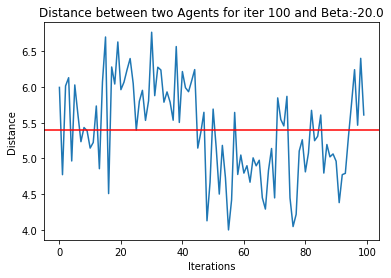

In [10]:

beta_array = np.linspace(-20,20,num=50)
for beta in beta_array:
    print(beta)
    game = RunAgents(True,beta)
    agent1 = GridWorld(epsilon = 0.2)
    agent2 = GridWorld(epsilon = 0.2)
    game.startTraining(agent1,agent2)
    game.train(100) #train for 200,000 iterations
    game.saveStates() 


distance_graph_array = np.array(distance_graph_array)
fig, ax = plt.subplots()
ax.plot(distance_graph_array.T[1],distance_graph_array.T[0])
plt.show()
